In [1]:
!pip install kaggle

In [7]:
!kaggle datasets download -d andrewmvd/sp-500-stocks

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks
License(s): CC0-1.0
 35%|█████████████▋                         | 15.0M/42.7M [00:50<01:19, 368kB/s]^C
 37%|██████████████▌                        | 16.0M/42.7M [00:52<01:28, 318kB/s]
User cancelled operation


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Построим модели Фамы-Френча на S&P 500 stocks датасете.

### Датасет `sp500_companies.csv`

Подробнее о колонках:

- Currentprice - текущая рыночная стоимость акции компании. Это значение отражает текущую рыночную стоимость акций компании на бирже. Оно может варьироваться в зависимости от спроса и предложения на рынке, а также от финансовой деятельности компании.

- Marketcap - рыночная стоимость компании. Это общая стоимость всех акций компании, умноженная на текущую рыночную стоимость одной акции. Рыночная стоимость компании является важным показателем, поскольку она отражает общее влияние компании на рынке.

- Ebitda - прибыль до вычета процентов, налогов, амортизации и амортизации (Earnings Before Interest, Taxes, Depreciation, and Amortization). EBITDA представляет собой чистую прибыль компании до учета всех налогов и амортизации. Этот показатель часто используется для оценки финансового здоровья компании, поскольку он позволяет сравнивать прибыль компаний, работающих в разных отраслях и странах.

- Revenuegrowth - рост доходов. Этот показатель отражает изменение доходов компании за определенный период времени. Показывает, насколько быстро растет доход компании, что может быть полезно для оценки ее роста и стабильности.
Weight - вес акции в индексе. Этот показатель отражает долю рыночной стоимости акции в общей рыночной стоимости всех акций в индексе. Он помогает инвесторов понять, насколько значительным является вклад конкретной компании в индекс.

In [38]:
companies_df = pd.read_csv('../data/market_data/sp500/sp500_companies.csv')
companies_df.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,413.54,3073557397504,1.251820e+11,0.170,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.063633
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,181.71,2786359508992,1.296290e+11,-0.043,Cupertino,CA,United States,150000.0,"Apple Inc. designs, manufactures, and markets ...",0.057687
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,921.40,2303499960320,3.448000e+10,2.653,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.047690
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,168.10,2087264059392,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,0.043213
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,169.83,2086904922112,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,0.043206


### Датасет `sp500_index.csv`

In [39]:
index_df = pd.read_csv(
    '../data/market_data/sp500/sp500_index.csv').set_index('Date')
index_df.head()

,S&P500
Date,
2014-05-07,1878.21
2014-05-08,1875.63
2014-05-09,1878.48
2014-05-12,1896.65
2014-05-13,1897.45


### Датасет `sp500_stocks.csv`

In [40]:
stocks_df = pd.read_csv('../data/market_data/sp500/sp500_stocks.csv')
stocks_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,40.835045,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,40.579273,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,41.154751,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,41.184265,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,41.474472,70.501671,70.501671,69.648827,69.974915,4073337.0


In [41]:
# свернем таблицу для простоты использования

pivoted_stocks_df = stocks_df.pivot(
    index='Date', columns='Symbol', values='Adj Close')

pivoted_stocks_df.head()

Symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122225,4.496877,6.470740,NaN,NaN,18.952158,7.994444,32.212463,37.090000,22.530378,...,52.883564,9.905467,41.538414,12.918812,40.237793,NaN,19.158094,52.587063,28.670000,NaN
2010-01-05,19.903641,5.005957,6.481928,NaN,NaN,18.799044,7.967778,32.411537,37.700001,22.494806,...,52.765034,10.115746,44.064743,12.765594,40.394901,NaN,19.092577,54.251747,28.620001,NaN
2010-01-06,19.832933,4.798555,6.378825,NaN,NaN,18.903440,7.933333,32.756092,37.619999,22.452118,...,53.614510,10.003899,43.486748,12.790112,40.744026,NaN,18.956091,54.234219,28.400000,NaN
2010-01-07,19.807213,4.939965,6.367032,NaN,NaN,19.060040,7.886667,32.725479,36.889999,22.274269,...,53.456459,9.959159,44.415436,12.734958,40.616020,NaN,18.950630,55.478359,27.690001,NaN
2010-01-08,19.800785,4.845691,6.409362,NaN,NaN,19.157482,7.871111,32.595295,36.689999,22.402325,...,53.397198,9.867442,44.097221,12.741084,40.453075,NaN,18.956091,54.313084,27.600000,NaN


## Про модель

#### Модель CAMP

$E(R_p) - RF = \beta_p (E(R_M) - RF)$

#### Модель Фамы Френча

$r = \alpha + r_f + \beta (r_m - r_f) + \gamma \cdot SMB + \phi \cdot HML + \xi_i$

$r - r_f = \alpha + \beta (r_m - r_f) + \gamma \cdot SMB + \phi \cdot HML + \xi_i$

## HML и SMB

Найдем HML и SMB для трехфакторной модели Фамы-Френча. 

Трехфакторная модель Фамы-Френча использует эти данные для расчета следующих фичей:

Моментум (Momentum): Изменение цены закрытия по сравнению с предыдущим днем.
Тренд (Trend): Изменение цены закрытия по сравнению с ценой открытия.
Торговый объем (Volume): Изменение объема торгов по сравнению с предыдущим днем.
Для расчета этих фичей, вы можете использовать следующие формулы:

- Моментум: Momentum = Close[t] - Close[t-1]
- Тренд: Trend = Close[t] - Open[t]
- Торговый объем: Volume = Volume[t] - Volume[t-1], где t обозначает текущий день, а t-1 - предыдущий день.

Пример расчета для первого дня данных:

Моментум: Momentum = 69.473244 - 69.414719 = 0.058525
Тренд: Trend = 69.473244 - 69.122070 = 0.351174
Торговый объем: Volume = 3640265.0 - 0 (поскольку это первый день) = 3640265.0

$HML_t = \frac{r_t (SV_t ) - r_t (SG_t )}{2} + \frac{r_t (BV_t ) - r_t (BG_t )}{2}$

$SMB_t = \frac{r_t (SG_t ) - r_t (BG_t )}{3} + \frac{r_t (SN_t )-r_t (BN_t )}{3} + \frac{r_t (SV_t )-r_t (BV_t )}{3}$

Ссылка на источник, как считать: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html

Чтобы рассчитать P/B (Price to Book) ratio для компаний, представленных в вашем списке, нам нужно знать два ключевых показателя: текущую рыночную стоимость (Market Cap) и бухгалтерскую стоимость активов (Book Value). В списке указаны текущие рыночные стоимости (Market Cap), но бухгалтерская стоимость активов не представлена напрямую. Однако, мы можем использовать EBITDA (Earnings Before Interest, Taxes, Depreciation, and Amortization) как приближение к бухгалтерской стоимости активов, так как EBITDA представляет собой чистую прибыль компании до учета процентов, налогов, амортизации и амортизации.

P/B ratio рассчитывается по формуле:

$\text{P/B Ratio} = \frac{\text{Market Cap}}{\text{Book Value}}$

Мы можем использовать EBITDA как приближение к Book Value, так как EBITDA является частью бухгалтерской стоимости активов.

$\Rightarrow \text{P/B Ratio} = \frac{\text{Market Cap}}{\text{Ebitda}}$

In [42]:
companies_df['pb_ratio'] = companies_df['Marketcap'] / companies_df['Ebitda']

In [43]:
category_threshold = 0.20  # Sets the Lower and Upper percentile cut-off.
cats = pd.DataFrame(companies_df['Symbol'])  # creates a category dataframe

# pb_ratio = market_cap / assets_book_value

for i in range(len(companies_df)):  # for each stock
    # Categorizes stocks as Small, Mid, and Big Market Capitalization
    if companies_df.iloc[i, :]['Marketcap'] < companies_df['Marketcap'].quantile(category_threshold):
        cats.at[i, 'size'] = 'small'
    elif companies_df.iloc[i, :]['Marketcap'] > companies_df['Marketcap'].quantile(1-category_threshold):
        cats.at[i, 'size'] = 'big'
    else:
        cats.at[i, 'size'] = 'mid'

    # Categorizes stocks as Low, Mid, and High Book-to-Market Ratio
    if companies_df.iloc[i, :]['pb_ratio'] < companies_df.pb_ratio.quantile(category_threshold):
        cats.at[i, 'value'] = 'low'
    elif companies_df.iloc[i, :]['pb_ratio'] > companies_df.pb_ratio.quantile(1-category_threshold):
        cats.at[i, 'value'] = 'high'
    else:
        cats.at[i, 'value'] = 'mid'
cats.head(10)  # so viewers can have a look

,Symbol,size,value
0,MSFT,big,high
1,AAPL,big,high
2,NVDA,big,high
3,GOOGL,big,mid
4,GOOG,big,mid
5,AMZN,big,mid
6,META,big,mid
7,BRK-B,big,low
8,LLY,big,high
9,AVGO,big,high


In [44]:
# compute the SMB returns
small = pivoted_stocks_df[cats[cats['size'] == 'small']
               ['Symbol']].pct_change(-1).mean(axis=1)
big = pivoted_stocks_df[cats[cats['size'] == 'big']
                        ['Symbol']].pct_change(-1).mean(axis=1)
# calculates the difference in the small returns and big returns
SMB = pd.DataFrame(small-big, columns=['SMB'])

# compute the HML returns
low = pivoted_stocks_df[cats[cats['value'] == 'low']
             ['Symbol']].pct_change(-1).mean(axis=1)
high = pivoted_stocks_df[cats[cats['value'] == 'high']
              ['Symbol']].pct_change(-1).mean(axis=1)
# calculates the difference in the high returns and low returns
HML = pd.DataFrame(high-low, columns=['HML'])

# compute the market premium
# risk_free_rate = (1+market_risk['IRX']/365)**365-1
# market_premium = pd.DataFrame(
#     market_risk['GSPC']-risk_free_rate, columns=['market_premium'])
# market_risk

# combine the 3 Fama-French factors
factors = pd.concat([SMB, HML], axis=1)
factors.head(10)  # so viewers can have a look

,SMB,HML
Date,,
2010-01-04,-0.004335,0.006945
2010-01-05,-0.002322,-0.002916
2010-01-06,-0.002326,-0.001214
2010-01-07,0.000020,-0.004778
2010-01-08,-0.000950,-0.000030
2010-01-11,-0.004208,0.003504
2010-01-12,-0.005219,-0.002496
2010-01-13,-0.000161,-0.000335
2010-01-14,0.000648,0.004081


In [45]:
factors.shape

(3609, 2)

Посчитаем доходность для индекса AAPL и подберем модель.

In [46]:
r_m = index_df['S&P500'].pct_change(-1)
# r_m.iloc[0] = 1

# r_f = pivoted_stocks_df['AAPL'] / pivoted_stocks_df['AAPL'].shift()
# r_f.iloc[0] = 1

In [47]:
risk_free_rate = r_m.mean()

In [48]:
market_premium = r_m - risk_free_rate
factors['market_premium'] = market_premium

In [49]:
factors.shape

(3609, 3)

Построим регрессию 3-факторной модели Фамы-Френча

In [50]:
def Fama_French_Metrics(symbol, factors, riskfree, sample):
    returns = pivoted_stocks_df[symbol].pct_change(-1)
    returns = pd.DataFrame(returns - riskfree)
    returns = returns.rename(columns={symbol: symbol + ' Return Premium'})
    returns = returns.dropna(axis=0)

    # delete later
    factors = factors.join(returns)
    factors = sm.add_constant(factors).dropna(axis=0)
    returns = factors[symbol + ' Return Premium']
    factors = factors.drop(columns=[symbol + ' Return Premium'])
    
    model = sm.OLS(returns, factors).fit()

    if model.pvalues.iloc[0] < 0.05:
        # statistically signiciant at the 5% level (could be lower)
        alpha = model.params.iloc[0]
    else:
        alpha = 0  # Inconclusive, not enough evidence to claim it is not zero.
    if model.pvalues.iloc[1] < 0.05:
        market_risk_beta = model.params.iloc[1]
    else:
        market_risk_beta = 0
    if model.pvalues.iloc[2] < 0.05:
        size_beta = model.params.iloc[2]
    else:
        size_beta = 0
    if model.pvalues.iloc[3] < 0.05:
        value_beta = model.params.iloc[3]
    else:
        value_beta = 0
    r2 = model.rsquared_adj

    if sample == True:
        vif_data = pd.DataFrame()
        vif_data['Variable'] = factors.columns
        vif_data['VIF'] = [variance_inflation_factor(
            factors.values, i) for i in range(factors.shape[1])]
    else:
        model = ''
        vif_data = ''
    return alpha, market_risk_beta, size_beta, value_beta, r2, model, vif_data

In [51]:
# returns the results for each stock
sample = Fama_French_Metrics('AAPL', factors, risk_free_rate, True)
print(sample[5].summary())  # Sample OLS Regression
print('\n')
print(sample[6])  # Sample OLS Regression

                             OLS Regression Results                            
Dep. Variable:     AAPL Return Premium   R-squared:                       0.606
Model:                             OLS   Adj. R-squared:                  0.606
Method:                  Least Squares   F-statistic:                     1290.
Date:                 Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                         15:33:14   Log-Likelihood:                 7728.6
No. Observations:                 2516   AIC:                        -1.545e+04
Df Residuals:                     2512   BIC:                        -1.543e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.664e-05      0.0

Выводы:

In [52]:
ff_stats = []
for stk in cats['Symbol']:
    ols_stats = Fama_French_Metrics(stk, factors, risk_free_rate, False)
    ff_stats.append([stk, ols_stats[0], ols_stats[1],
                    ols_stats[2], ols_stats[3], ols_stats[4]])

ff_stats = pd.DataFrame(ff_stats, columns=[
                        'symbol', 'alpha', 'market_premium_beta', 'size_beta', 'value_beta', 'r-squared'])
output = pd.concat([ff_stats.set_index('symbol'),
                   cats.set_index('Symbol')], axis=1)
output

,alpha,market_premium_beta,size_beta,value_beta,r-squared,size,value
MSFT,0.0,-0.503769,0.357548,1.178606,0.717464,big,high
AAPL,0.0,-0.267590,0.322972,1.160617,0.605968,big,high
NVDA,0.0,0.000000,1.135758,1.554885,0.538271,big,high
GOOGL,0.0,-0.356385,0.293223,1.118232,0.575502,big,mid
GOOG,0.0,-0.349435,0.286532,1.114638,0.569223,big,mid
...,...,...,...,...,...,...,...
RHI,0.0,0.979674,0.000000,1.031253,0.447915,small,mid
ETSY,0.0,2.285732,1.629635,1.117474,0.297159,small,mid
CMA,0.0,1.415557,-0.663562,1.400066,0.515223,small,mid
NCLH,0.0,2.648513,-0.419373,1.743848,0.420700,small,low


## Regression Output Charts

#### Сравнение размеров

Далее рассматриваются гистограммы акций мелких и крупных компаний, поэтому акции среднего размера исключаются из выборки. Можно заметить, что бета-распределения по размерам выглядят несколько иначе, поэтому далее можно найти t-критерий для независимых выборок, который проверяет равенство средних значений.

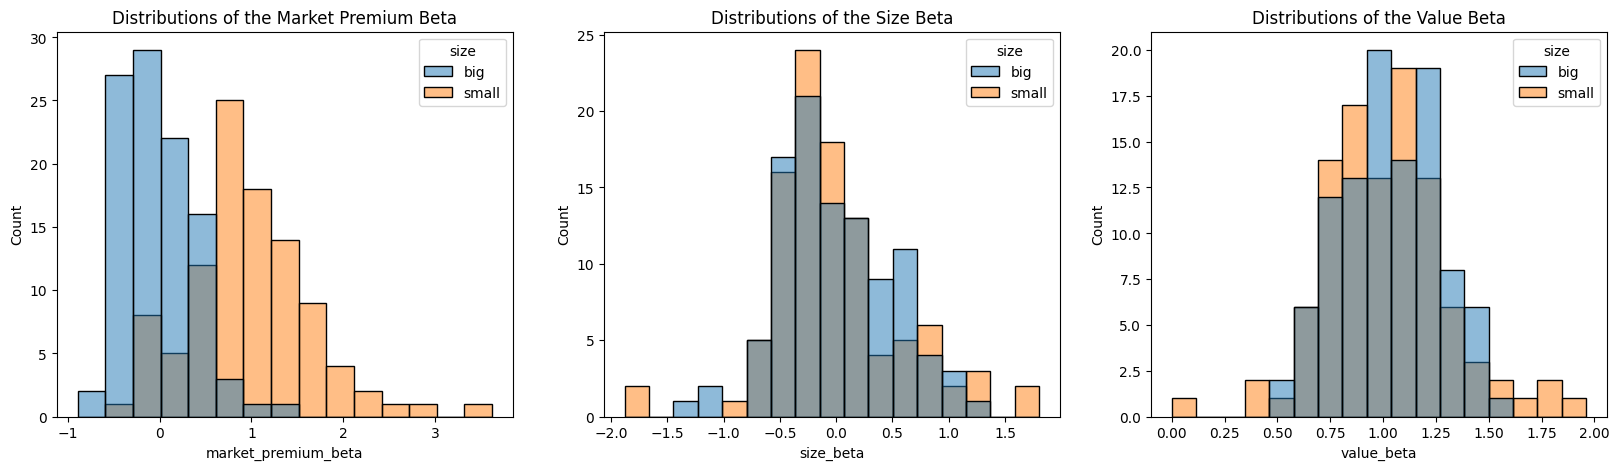

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
outsize = output[~(output['size'] == 'mid')]
sns.histplot(x=outsize['market_premium_beta'], hue=outsize['size'], ax=axes[0])
sns.histplot(x=outsize['size_beta'], hue=outsize['size'], ax=axes[1])
sns.histplot(x=outsize['value_beta'], hue=outsize['size'], ax=axes[2])
axes[0].set_title('Distributions of the Market Premium Beta')
axes[1].set_title('Distributions of the Size Beta')
axes[2].set_title('Distributions of the Value Beta')
plt.show()

#### Сравнение значений

Ниже рассматриваются гистограммы акций стоимости и роста, поэтому акции средней стоимости исключаются из выборки. Можно заметить, что бета-распределения значений выглядят несколько иначе, поэтому далее можно найти t-тест для независимых выборок, которые проверяют равенство средних значений.

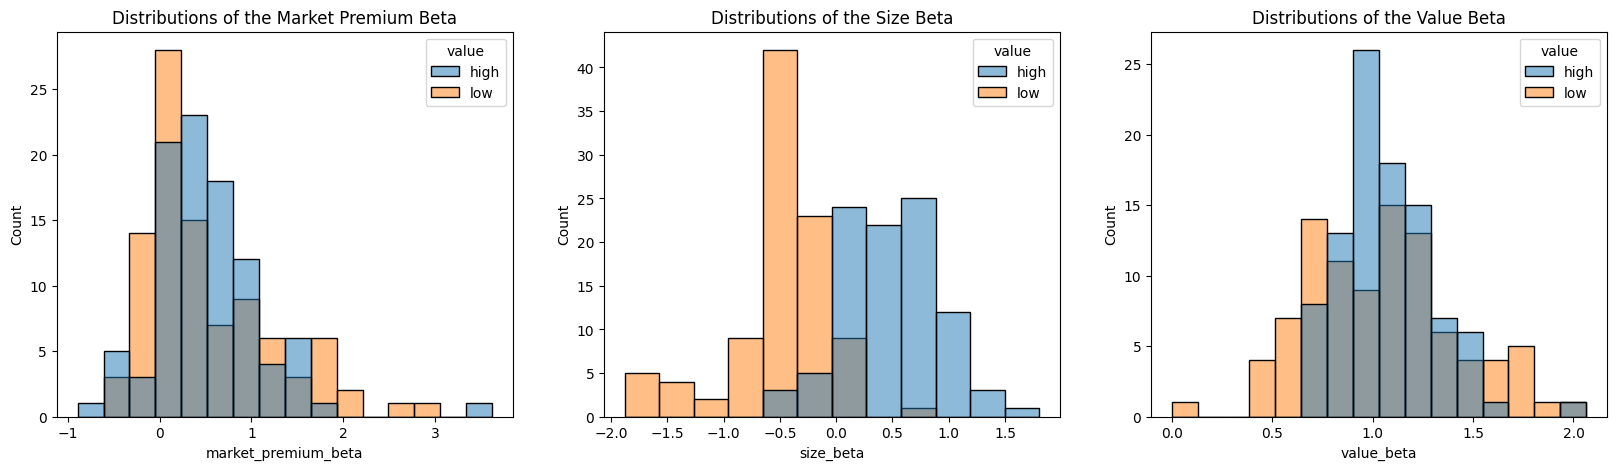

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
outvalue = output[~(output['value'] == 'mid')]
sns.histplot(x=outvalue['market_premium_beta'],
             hue=outvalue['value'], ax=axes[0])
sns.histplot(x=outvalue['size_beta'], hue=outvalue['value'], ax=axes[1])
sns.histplot(x=outvalue['value_beta'], hue=outvalue['value'], ax=axes[2])
axes[0].set_title('Distributions of the Market Premium Beta')
axes[1].set_title('Distributions of the Size Beta')
axes[2].set_title('Distributions of the Value Beta')
plt.show()

#### Коэффициент детерминации сравнения

Ниже рассматриваются гистограммы коэффициента детерминации между акциями мелких и крупных компаний, а также между акциями стоимости и акциями роста. Может быть трудно определить, одинаковы ли распределения, поэтому далее можно найти t-критерии для независимых выборок, которые проверяют равенство средних значений.

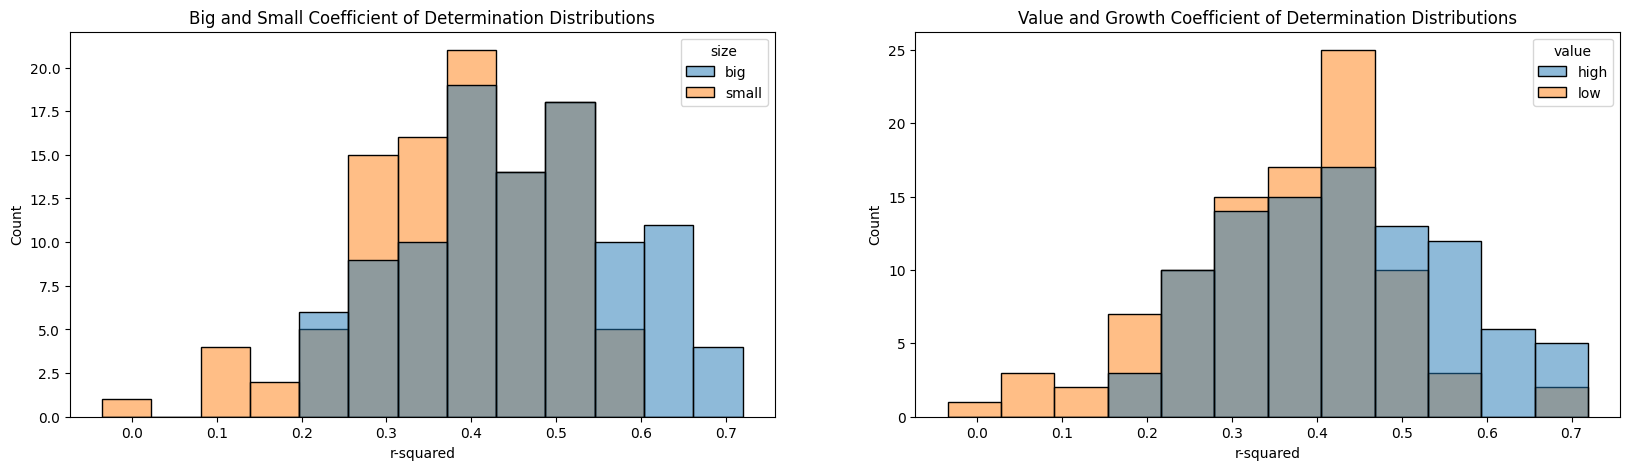

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(x=outsize['r-squared'], hue=outsize['size'], ax=axes[0])
sns.histplot(x=outvalue['r-squared'], hue=outvalue['value'], ax=axes[1])
axes[0].set_title('Big and Small Coefficient of Determination Distributions')
axes[1].set_title(
    'Value and Growth Coefficient of Determination Distributions')
plt.show()

## T-tests

#### T-Tests on Small vs. Big β<sub>SMB</sub> and High vs. Low β<sub>HML</sub>

Можно наблюдать статистически значимую разницу между средними значениями R<sup>2</sup> акций крупных и мелких компаний. Разница в средних значениях R<sup>2</sup> акций стоимости и акций роста статистически значима на уровне значимости 10 %, но не на уровне значимости 5 %.

In [56]:
print('T-test of size beta between small and large stocks')
p_value = stats.ttest_ind(output[output['size'] == 'small']
                          ['size_beta'], output[output['size'] == 'big']['size_beta'])[1]
print('P-value = ' + str(p_value))
print('\nT-test of value beta between low and high price-to-book ratio')
p_value = stats.ttest_ind(output[output['value'] == 'low']['value_beta'],
                          output[output['value'] == 'high']['value_beta'])[1]
print('P-value = ' + str(p_value))

T-test of size beta between small and large stocks
P-value = 0.9582810267356426

T-test of value beta between low and high price-to-book ratio
P-value = 0.5442826211582686


#### T-Tests on Small vs. Big R<sup>2</sup> and High vs. Low R<sup>2</sup>

Можно наблюдать статистически значимую разницу между средними значениями R<sup>2</sup> акций крупных и мелких компаний. Разница в средних значениях R<sup>2</sup> акций стоимости и акций роста статистически значима на уровне значимости 10 %, но не на уровне значимости 5 %.

In [57]:
print('T-test of R-squared between small and large stocks')
p_value = stats.ttest_ind(output[output['size'] == 'small']
                          ['r-squared'], output[output['size'] == 'big']['r-squared'])[1]
print('P-value = ' + str(p_value))
print('\nT-test of R-squared between growth and value stocks')
p_value = stats.ttest_ind(output[output['value'] == 'low']['r-squared'],
                          output[output['value'] == 'high']['r-squared'])[1]
print('P-value = ' + str(p_value))

T-test of R-squared between small and large stocks
P-value = 2.8593459859673357e-05

T-test of R-squared between growth and value stocks
P-value = 0.0002235169589382788


## Conclusion

In [58]:
factors.to_csv('../data/sp500_preprocess.csv')